In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def load_data_from_mat(path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith('train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith('test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels


def apply_fft_and_split(data):
    """
    对数据执行一维FFT变换，并分离实部和虚部。
    
    Parameters:
    - data: 形状为 (n_samples, n_features) 的数组
    
    Returns:
    - FFT变换后数据的实部和虚部
    """
    fft_data = np.fft.fft(data, axis=-1)
    return np.real(fft_data), np.imag(fft_data)

In [2]:
# 调用函数加载数据
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path)

train_data_origin = train_data
test_data_origin = test_data

# train_data_z = train_data / np.max(train_data)
# test_data_z = test_data / np.max(test_data)

# 应用FFT变换并分离实部和虚部
train_data_fft_real, train_data_fft_imag = apply_fft_and_split(train_data)
test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

# 合并实部和虚部为模型的输入
train_data_fft_combined = np.concatenate((train_data_fft_real, train_data_fft_imag), axis=-1)
test_data_fft_combined = np.concatenate((test_data_fft_real, test_data_fft_imag), axis=-1)

def compute_magnitude_phase(data_fft_real, data_fft_imag):
    magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
    phase = np.arctan2(data_fft_imag, data_fft_real)
    return magnitude, phase

# 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
train_magnitude, train_phase = compute_magnitude_phase(train_data_fft_real, train_data_fft_imag)
test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)

# 将幅度和相位合并为模型输入
# train_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)
# test_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)

half_train_magnitude = train_magnitude[:, :1536]
half_test_magnitude = test_magnitude[:, :1536]
half_train_data_fft_real = train_data_fft_real[:, :1536]
half_train_data_fft_imag = train_data_fft_imag[:, :1536]
half_test_data_fft_real = test_data_fft_real[:, :1536]
half_test_data_fft_imag = test_data_fft_imag[:, :1536]
# print(train_magnitude.shape)
# print(half_train_phase.shape)
# 然后可以用这些数据来训练你的模型
train_data_combined = np.concatenate((half_train_magnitude, half_train_data_fft_real, half_train_data_fft_imag), axis=-1)
test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)
print(train_data_combined.shape)
print(test_data_combined.shape)
# train_data_fft_combined = np.concatenate((train_data_origin, train_data_combined), axis=-1)
# test_data_fft_combined = np.concatenate((test_data_origin, test_data_combined), axis=-1)
# print(train_data_fft_combined.shape)
# print(test_data_fft_combined.shape)
# print('Train data shape:', train_data_combined.shape)
# print('Train labels shape:', train_labels.shape)
# print('Test data shape:', test_data_combined.shape)
# print('Test labels shape:', test_labels.shape)
# # 根据FFT结果调整数据形状，此处仅为示例，实际需要根据FFT变换后的数据形状进行调整


(126000, 4608)
(14000, 4608)


In [3]:
# train_data_fft_reshaped = train_data_fft_combined.reshape((-1, 32, 48, 4))
# test_data_fft_reshaped = test_data_fft_combined.reshape((-1, 32, 48, 4))
train_data_fft_reshaped = train_data_combined.reshape((-1, 32, 48, 3))
test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))
print('Train data shape:', train_data_fft_reshaped.shape)
print('Test data shape:', test_data_fft_reshaped.shape)

Train data shape: (126000, 32, 48, 3)
Test data shape: (14000, 32, 48, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, ReLU

def build_simplified_mobilenet_model(input_shape=(32, 48, 3), num_classes=10):
    model = Sequential([
        # 简化版 Block 1 - Depthwise Convolution
        DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation=None, input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, (1, 1), padding='same', activation='relu'),  # 减少了输出通道数
        MaxPooling2D(pool_size=(2, 2)),
        
        # 简化版 Block 2 - Depthwise Convolution
        DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation=None),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, (1, 1), padding='same', activation='relu'),  # 减少了输出通道数
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),  # 减少了神经元数量
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# 根据加载的数据设置模型
model = build_simplified_mobilenet_model(input_shape=(32, 48, 3), num_classes=10)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 输出模型概况
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depthwise_conv2d_2              │ (None, 32, 48, 3)      │            30 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 48, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 16, 24, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 24, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 12, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 790,580 (3.02 MB)

 Trainable params: 790,510 (3.02 MB)

 Non-trainable params: 70 (280.00 B)

In [7]:
# 训练模型
history = model.fit(train_data_fft_reshaped, train_labels,
                    batch_size=64,
                    epochs=30,  # 可以调整为合适的值
                    validation_split=0.1,
                    shuffle=True)



Epoch 1/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.4179 - loss: 1.4280 - val_accuracy: 0.5471 - val_loss: 0.9552
Epoch 2/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - accuracy: 0.5811 - loss: 0.9589 - val_accuracy: 0.7273 - val_loss: 0.7290
Epoch 3/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 59s 33ms/step - accuracy: 0.6213 - loss: 0.8715 - val_accuracy: 0.6337 - val_loss: 0.7281
Epoch 4/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.6515 - loss: 0.8096 - val_accuracy: 0.6833 - val_loss: 0.6591
Epoch 5/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.6611 - loss: 0.7814 - val_accuracy: 0.7848 - val_loss: 0.5731
Epoch 6/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.6921 - loss: 0.7250 - val_accuracy: 0.6990 - val_loss: 0.7057
Epoch 7/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 59s 33ms/step - accuracy: 0.7116 - loss: 0.6957 - val_accuracy: 0.7134 - val_loss: 0.6679
Epoch 8/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 59s 33ms/step - accuracy: 0.7151 -

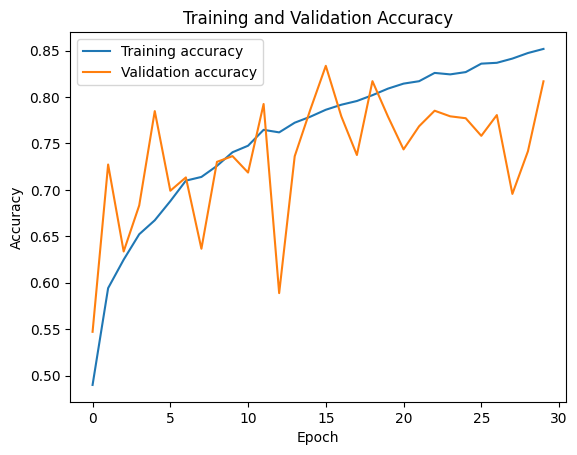

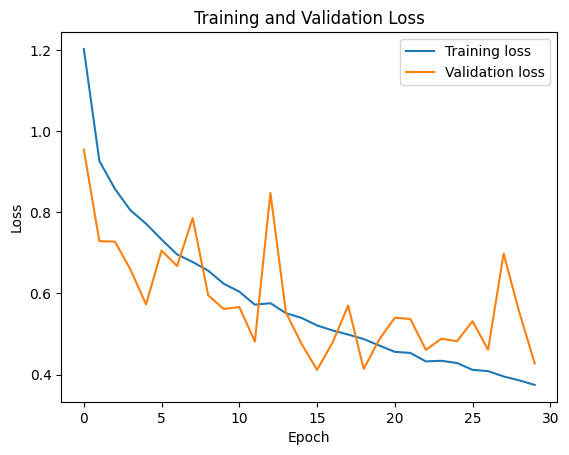

In [8]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-mobilenet-1.h5')  # HDF5文件


In [10]:
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-mobilenet-1.h5')
# 评估模型在测试集上的性能
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)

print(f'测试集损失: {test_loss}')
print(f'测试集准确率: {test_acc}')


438/438 - 3s - 7ms/step - accuracy: 0.6914 - loss: 0.7107
测试集损失: 0.7107324600219727
测试集准确率: 0.691428542137146


438/438 - 3s - 7ms/step - accuracy: 0.6914 - loss: 0.7107

Test accuracy: 0.691428542137146
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
              precision    recall  f1-score   support

           0       0.47      0.48      0.47      1400
           1       0.98      1.00      0.99      1400
           2       0.56      0.68      0.62      1400
           3       0.81      0.54      0.65      1400
           4       1.00      1.00      1.00      1400
           5       0.97      0.71      0.82      1400
           6       0.51      0.61      0.55      1400
           7       0.95      0.99      0.97      1400
           8       0.51      0.45      0.48      1400
           9       0.37      0.44      0.40      1400

    accuracy                           0.69     14000
   macro avg       0.71      0.69      0.70     14000
weighted avg       0.71      0.69      0.70     14000



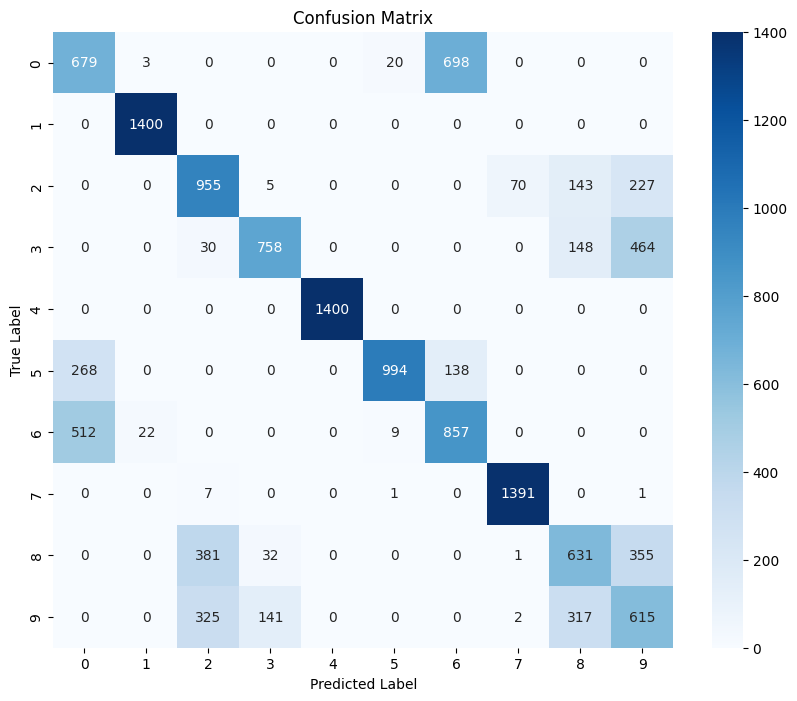

In [11]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# def load_data_from_mat(path,dBnumber):
#     train_data = []
#     train_labels = []
#     test_data = []
#     test_labels = []

#     for file in os.listdir(path):
#         if file.startswith(f'train_'):
#             mat = scipy.io.loadmat(os.path.join(path, file))
#             train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
#             train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
#         elif file.startswith(f'test_'):
#             mat = scipy.io.loadmat(os.path.join(path, file))
#             test_data.append(mat[list(mat.keys())[-2]])
#             test_labels.append(mat[list(mat.keys())[-1]])

#     # Concatenate all data and labels respectively
#     train_data = np.concatenate(train_data, axis=0)
#     train_labels = np.concatenate(train_labels, axis=0)
#     test_data = np.concatenate(test_data, axis=0)
#     test_labels = np.concatenate(test_labels, axis=0)
#     # print(test_data.shape, test_labels.shape)

#     # Normalize data
#     train_data = train_data.astype('float32') / 255
#     test_data = test_data.astype('float32') / 255

#     # Convert labels to categorical (one-hot encoding)
#     train_labels = to_categorical(train_labels, 10)
#     test_labels = to_categorical(test_labels, 10)

#     return train_data, train_labels, test_data, test_labels

# # 调用函数加载数据
# dBnumber = 0
# path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
# train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)

# train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
# test_data_reshaped = test_data.reshape((-1, 32, 32, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


(12000, 4608)
375/375 - 2s - 6ms/step - accuracy: 0.7126 - loss: 0.6626

Test accuracy: 0.7125833630561829
Test loss: 0.662568986415863
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.49      0.52      0.51      1200
           1       0.99      1.00      0.99      1200
           2       0.57      0.72      0.63      1200
           3       0.83      0.59      0.69      1200
           4       1.00      1.00      1.00      1200
           5       0.99      0.78      0.87      1200
           6       0.53      0.60      0.56      1200
           7       0.96      1.00      0.98      1200
           8       0.55      0.47      0.50      1200
           9       0.39      0.44      0.42      1200

    accuracy                           0.71     12000
   macro avg       0.73      0.71      0.72     12000
weighted avg       0.73      0.71      0.72     12000



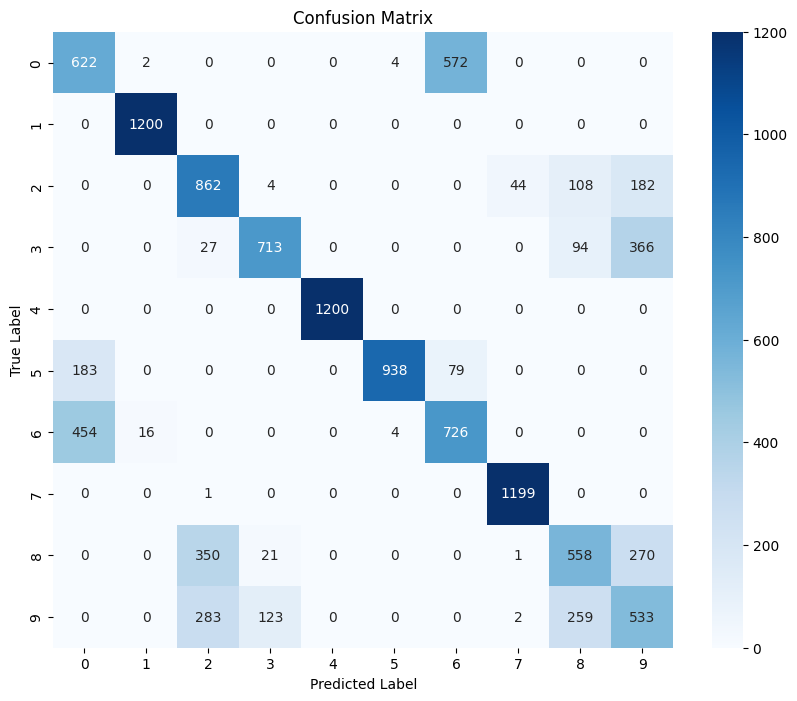

In [14]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-mobilenet-1.h5')
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def data_geneter_test():
    def load_data_from_mat(path):

        test_data = []
        test_labels = []

        for file in os.listdir(path):
            if file.startswith('test_'):
                mat = scipy.io.loadmat(os.path.join(path, file))
                test_data.append(mat[list(mat.keys())[-2]])
                test_labels.append(mat[list(mat.keys())[-1]])

        # Concatenate all data and labels respectively
        test_data = np.concatenate(test_data, axis=0)
        test_labels = np.concatenate(test_labels, axis=0)

        # Normalize data
        test_data = test_data.astype('float32') / 255

        # Convert labels to categorical (one-hot encoding)
        test_labels = to_categorical(test_labels, 10)

        return test_data, test_labels

    def apply_fft_and_split(data):
        """
        对数据执行一维FFT变换，并分离实部和虚部。
        
        Parameters:
        - data: 形状为 (n_samples, n_features) 的数组
        
        Returns:
        - FFT变换后数据的实部和虚部
        """
        fft_data = np.fft.fft(data, axis=-1)
        return np.real(fft_data), np.imag(fft_data)

    # 调用函数加载数据
    path = '/Users/fuyao/Desktop/Thesis/about_database/generate_database'
    test_data, test_labels = load_data_from_mat(path)


    # 应用FFT变换并分离实部和虚部
    test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

    def compute_magnitude_phase(data_fft_real, data_fft_imag):
        magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
        phase = np.arctan2(data_fft_imag, data_fft_real)
        return magnitude, phase

    # 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
    test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)


    half_test_magnitude = test_magnitude[:, :1536]
    half_test_data_fft_real = test_data_fft_real[:, :1536]
    half_test_data_fft_imag = test_data_fft_imag[:, :1536]

    # 然后可以用这些数据来训练你的模型

    test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)

    print(test_data_combined.shape)

    test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))

    return test_data_fft_reshaped, test_labels

def data_geneter_test_specific(dNumber):
    def load_data_from_mat(path):

        test_data = []
        test_labels = []

        for file in os.listdir(path):
            if file.startswith(f'test_{dNumber}'):
                mat = scipy.io.loadmat(os.path.join(path, file))
                test_data.append(mat[list(mat.keys())[-2]])
                test_labels.append(mat[list(mat.keys())[-1]])

        # Concatenate all data and labels respectively
        test_data = np.concatenate(test_data, axis=0)
        test_labels = np.concatenate(test_labels, axis=0)

        # Normalize data
        test_data = test_data.astype('float32') / 255

        # Convert labels to categorical (one-hot encoding)
        test_labels = to_categorical(test_labels, 10)

        return test_data, test_labels

    def apply_fft_and_split(data):
        """
        对数据执行一维FFT变换，并分离实部和虚部。
        
        Parameters:
        - data: 形状为 (n_samples, n_features) 的数组
        
        Returns:
        - FFT变换后数据的实部和虚部
        """
        fft_data = np.fft.fft(data, axis=-1)
        return np.real(fft_data), np.imag(fft_data)

    # 调用函数加载数据
    path = '/Users/fuyao/Desktop/Thesis/about_database/generate_database'
    test_data, test_labels = load_data_from_mat(path)


    # 应用FFT变换并分离实部和虚部
    test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

    def compute_magnitude_phase(data_fft_real, data_fft_imag):
        magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
        phase = np.arctan2(data_fft_imag, data_fft_real)
        return magnitude, phase

    # 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
    test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)


    half_test_magnitude = test_magnitude[:, :1536]
    half_test_data_fft_real = test_data_fft_real[:, :1536]
    half_test_data_fft_imag = test_data_fft_imag[:, :1536]

    # 然后可以用这些数据来训练你的模型

    test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)

    print(test_data_combined.shape)

    test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))

    return test_data_fft_reshaped, test_labels

test_data_fft_reshaped, test_labels = data_geneter_test()
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



(2000, 4608)
63/63 - 1s - 8ms/step - accuracy: 0.7605 - loss: 0.5187

Test accuracy: 0.7605000138282776
Test loss: 0.5186843872070312
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.60      0.46      0.52       200
           1       1.00      1.00      1.00       200
           2       0.64      0.70      0.67       200
           3       0.87      0.69      0.77       200
           4       1.00      1.00      1.00       200
           5       1.00      0.99      1.00       200
           6       0.56      0.69      0.62       200
           7       1.00      1.00      1.00       200
           8       0.62      0.52      0.56       200
           9       0.43      0.55      0.48       200

    accuracy                           0.76      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.77      0.76      0.76      2000



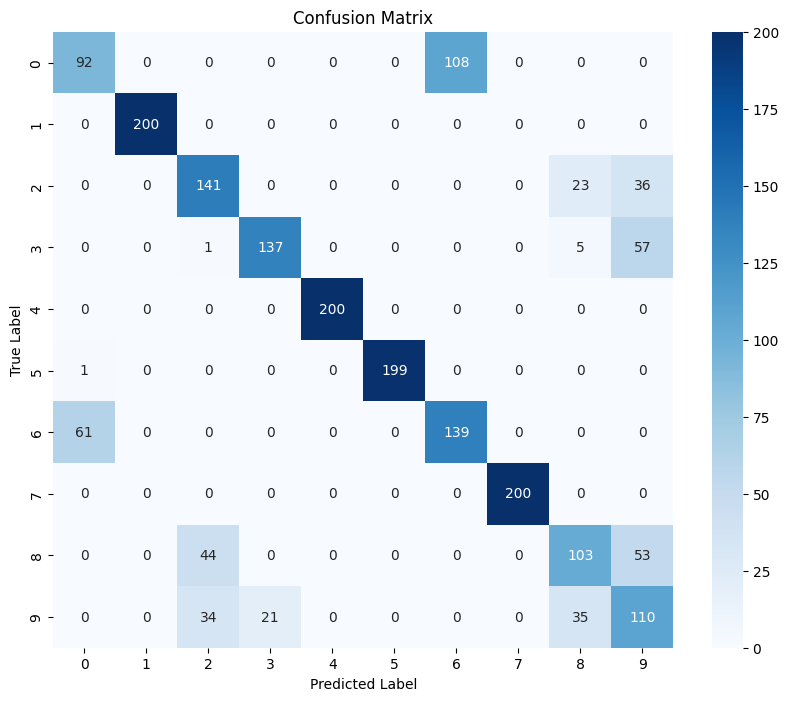

In [15]:
dNumber = 30
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 1s - 8ms/step - accuracy: 0.7620 - loss: 0.5335

Test accuracy: 0.7620000243186951
Test loss: 0.5335086584091187
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       200
           1       1.00      1.00      1.00       200
           2       0.63      0.70      0.67       200
           3       0.90      0.69      0.78       200
           4       1.00      1.00      1.00       200
           5       1.00      0.98      0.99       200
           6       0.56      0.66      0.61       200
           7       1.00      1.00      1.00       200
           8       0.61      0.55      0.58       200
           9       0.44      0.55      0.49       200

    accuracy                           0.76      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.77      0.76      0.76      2000



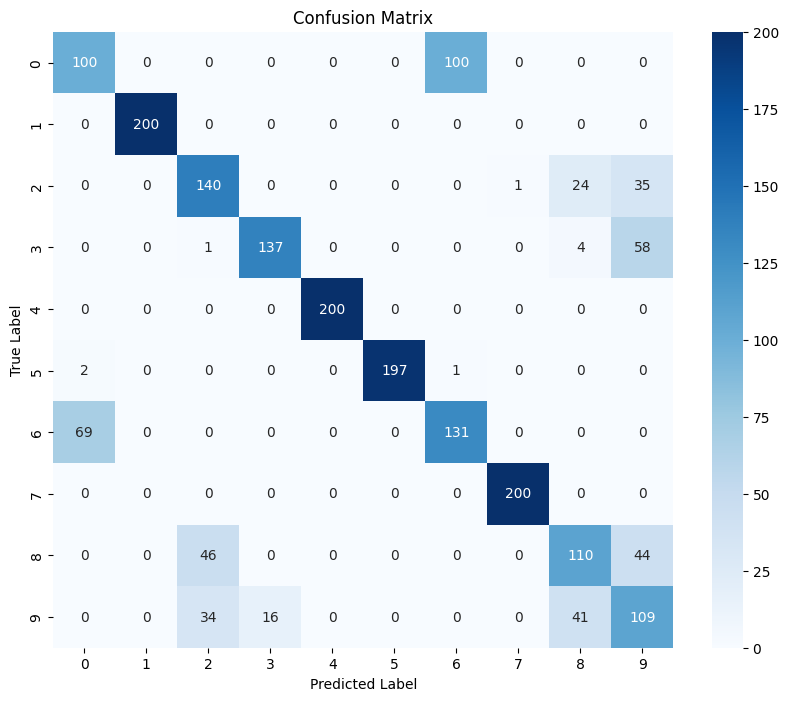

In [16]:
dNumber = 25
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 0s - 7ms/step - accuracy: 0.7505 - loss: 0.5767

Test accuracy: 0.7505000233650208
Test loss: 0.5767208337783813
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       200
           1       1.00      1.00      1.00       200
           2       0.57      0.80      0.66       200
           3       0.90      0.65      0.76       200
           4       1.00      1.00      1.00       200
           5       1.00      0.91      0.95       200
           6       0.58      0.58      0.58       200
           7       0.99      1.00      1.00       200
           8       0.64      0.49      0.56       200
           9       0.44      0.47      0.45       200

    accuracy                           0.75      2000
   macro avg       0.77      0.75      0.75      2000
weighted avg       0.77      0.75      0.75      2000



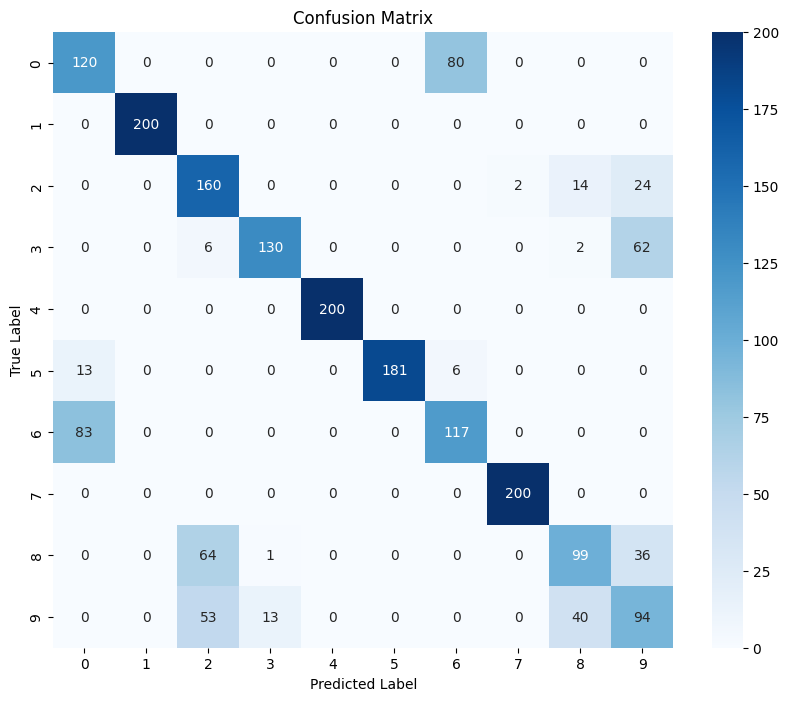

In [17]:
dNumber = 20
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 0s - 7ms/step - accuracy: 0.7145 - loss: 0.6932

Test accuracy: 0.7145000100135803
Test loss: 0.6931660771369934
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.49      0.70      0.58       200
           1       1.00      1.00      1.00       200
           2       0.49      0.89      0.63       200
           3       0.85      0.63      0.72       200
           4       1.00      1.00      1.00       200
           5       1.00      0.77      0.87       200
           6       0.59      0.47      0.52       200
           7       0.98      1.00      0.99       200
           8       0.60      0.34      0.44       200
           9       0.39      0.34      0.36       200

    accuracy                           0.71      2000
   macro avg       0.74      0.71      0.71      2000
weighted avg       0.74      0.71      0.71      2000



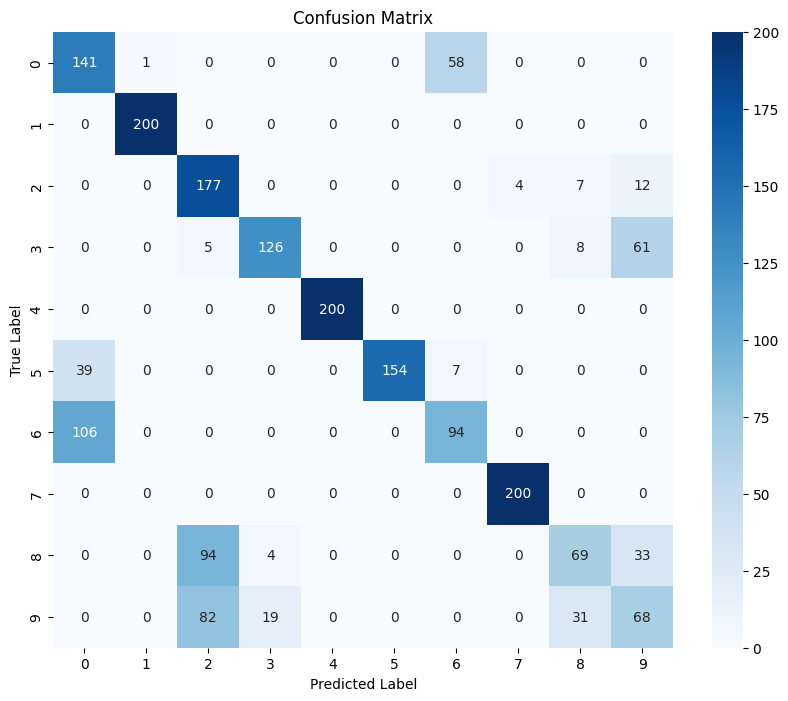

In [18]:
dNumber = 15
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 0s - 7ms/step - accuracy: 0.6860 - loss: 0.7525

Test accuracy: 0.6859999895095825
Test loss: 0.7524715662002563
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.44      0.48      0.46       200
           1       1.00      1.00      1.00       200
           2       0.59      0.68      0.63       200
           3       0.74      0.53      0.61       200
           4       1.00      1.00      1.00       200
           5       0.98      0.65      0.78       200
           6       0.51      0.63      0.56       200
           7       0.95      0.99      0.97       200
           8       0.49      0.51      0.50       200
           9       0.37      0.39      0.38       200

    accuracy                           0.69      2000
   macro avg       0.71      0.69      0.69      2000
weighted avg       0.71      0.69      0.69      2000



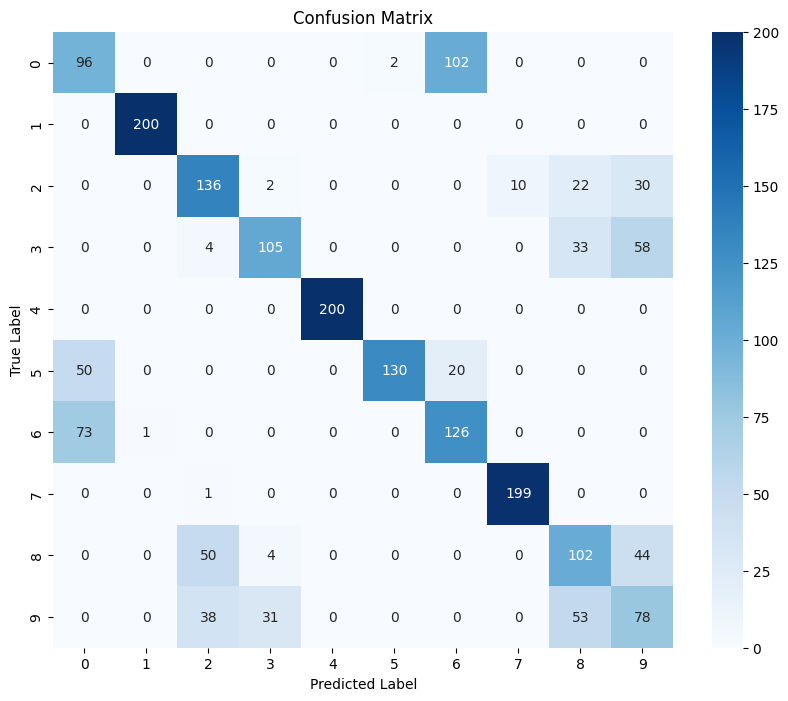

In [19]:
dNumber = 10
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 0s - 7ms/step - accuracy: 0.6020 - loss: 0.9340

Test accuracy: 0.6019999980926514
Test loss: 0.9340493083000183
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.34      0.36      0.35       200
           1       0.93      1.00      0.96       200
           2       0.51      0.54      0.52       200
           3       0.68      0.39      0.50       200
           4       1.00      1.00      1.00       200
           5       0.93      0.39      0.54       200
           6       0.41      0.59      0.49       200
           7       0.87      1.00      0.93       200
           8       0.39      0.38      0.38       200
           9       0.30      0.37      0.33       200

    accuracy                           0.60      2000
   macro avg       0.64      0.60      0.60      2000
weighted avg       0.64      0.60      0.60      2000



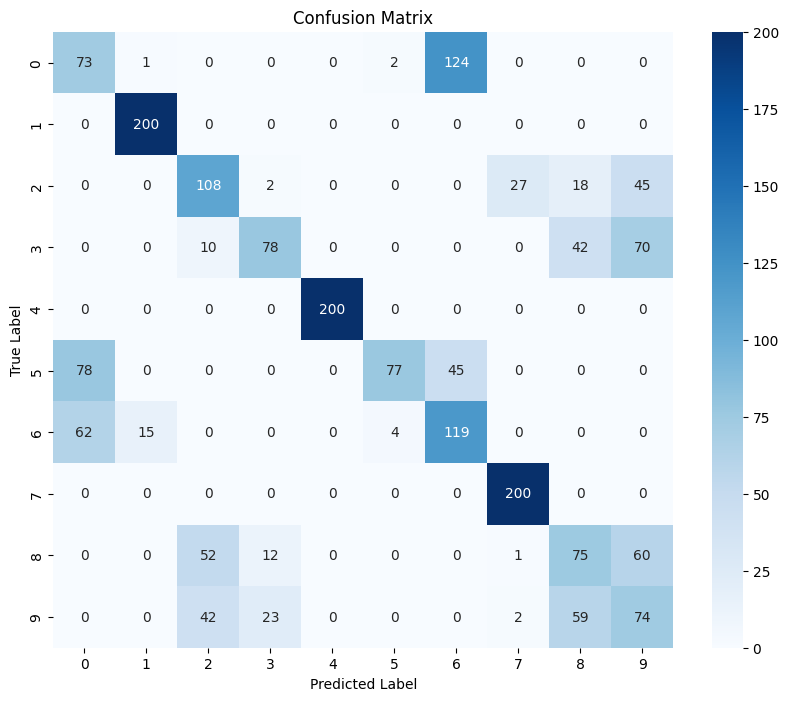

In [20]:
dNumber = 5
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()